# **Cat vs Dog Image Classification**

using Kaggle: Cat vs Dog Dataset

proposed models: CNN, ResNet, k-NN, SVM, GBM

In [ ]:
from google.colab import drive
import os
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the dataset in Google Drive
zip_file_path = '/content/drive/My Drive/CatvsDog.zip'
extracted_folder_path = '/content/Projects'

# Function to unzip files
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Unzipped {zip_path} to {extract_to}")

# Check if the file exists
if os.path.exists(zip_file_path):
    # Check if the file is a zip file
    if zip_file_path.lower().endswith('.zip'):
        # Create the folder where files will be extracted
        os.makedirs(extracted_folder_path, exist_ok=True)
        # Unzip the file
        unzip_file(zip_file_path, extracted_folder_path)
    else:
        print("The file is not a zip file. Proceeding normally.")
else:
    print(f"Error: The file '{zip_file_path}' does not exist.")


Mounted at /content/drive
Unzipped /content/drive/My Drive/CatvsDog.zip to /content/Projects


Sample Cat Images:


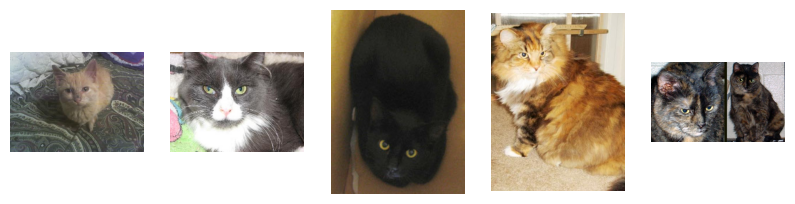

Sample Dog Images:


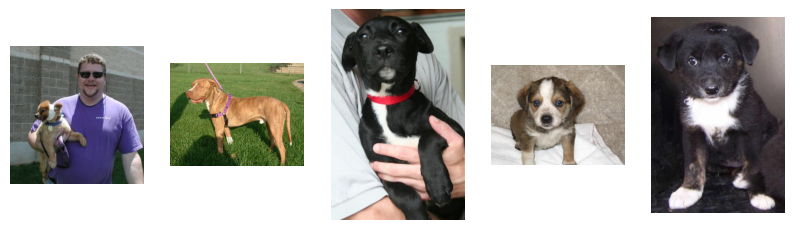

Number of cat images: 12490
Number of dog images: 12469


In [ ]:
myProject = '/content/Projects/CatvsDog'
PetImages = os.path.join(myProject, 'PetImages')
# Check if 'PetImages' exists, if not, print an error message and exit
if not os.path.exists(PetImages):
    print(f"Error: The folder '{PetImages}' does not exist.")
    # Exit the script if 'PetImages' is not found
    import sys
    sys.exit(1)

# Construct paths to 'Cat' and 'Dog' directories within 'PetImages'
Cats = os.path.join(PetImages, 'Cat')
Dogs = os.path.join(PetImages, 'Dog')

# Check if 'Cat' and 'Dog' directories exist, if not, print error messages
if not os.path.exists(Cats):
    print(f"Error: The folder '{Cats}' does not exist.")
if not os.path.exists(Dogs):
    print(f"Error: The folder '{Dogs}' does not exist.")

def display_sample_images(folder_path, num_samples=5):
    # Get a list of image files in the folder
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
    # Select a sample of images for display
    sample_images = images[:num_samples]
    # Create a figure for the images
    plt.figure(figsize=(10, 10))
    # Iterate through the sample images and display them
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis labels
    plt.show()

print("Sample Cat Images:")
display_sample_images(Cats)

print("Sample Dog Images:")
display_sample_images(Dogs)

# Count the number of cat and dog images
num_cat_images = len([f for f in os.listdir(Cats) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
num_dog_images = len([f for f in os.listdir(Dogs) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

print(f"Number of cat images: {num_cat_images}")
print(f"Number of dog images: {num_dog_images}")

In [ ]:
def preprocess_image(image_path, target_size=(128, 128)):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    image = image.resize(target_size)  # Resize image
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

def load_and_preprocess_images(folder_path, target_size=(128, 128), max_images=1000):
    images = []
    labels = []
    image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

    for img_file in image_files[:max_images]:  # Limit to max_images
        images.append(preprocess_image(img_file, target_size))
        labels.append(folder_path.split('/')[-1])  # Use folder name as label

    return np.array(images), np.array(labels)

# Preprocess cat and dog images
cat_images, cat_labels = load_and_preprocess_images(Cats)
dog_images, dog_labels = load_and_preprocess_images(Dogs)

# Combine cat and dog images and labels
X = np.concatenate((cat_images, dog_images), axis=0)
y = np.concatenate((cat_labels, dog_labels), axis=0)


In [ ]:
from sklearn.model_selection import train_test_split

# Encode labels as integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Verify the split
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 1600, Testing samples: 400


In [ ]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(buffer_size=1024)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,          # Rescale pixel values to [0, 1]
    rotation_range=40,          # Randomly rotate images in the range (degrees, 0 to 40)
    width_shift_range=0.2,      # Randomly translate images horizontally (fraction of total width)
    height_shift_range=0.2,     # Randomly translate images vertically (fraction of total height)
    shear_range=0.2,            # Randomly apply shearing transformations
    zoom_range=0.2,             # Randomly zoom in on images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill mode for new pixels created by augmentation
)

# Use a separate ImageDataGenerator for validation data (without augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Define paths to the training and validation directories
train_dir = '/content/Projects/CatvsDog/PetImages'  # Update this with the correct path
val_dir = '/content/Projects/CatvsDog/PetImages'    # Update this with the correct path

# Create augmented data generator for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,
    class_mode='binary'      # Binary classification
)

# Create a generator for validation data (without augmentation)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 24959 images belonging to 2 classes.
Found 24959 images belonging to 2 classes.


## **CNN**

In [ ]:
# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with augmented data
history = model.fit(
    train_generator,
    epochs=15,  # Increase epochs as needed
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 1409s 2s/step - accuracy: 0.5373 - loss: 0.6877 - val_accuracy: 0.6171 - val_loss: 0.6387
Epoch 2/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 1427s 2s/step - accuracy: 0.6562 - loss: 0.6159 - val_accuracy: 0.7466 - val_loss: 0.5172
Epoch 3/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 1389s 2s/step - accuracy: 0.7083 - loss: 0.5581 - val_accuracy: 0.7842 - val_loss: 0.4702
Epoch 4/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 1368s 2s/step - accuracy: 0.7498 - loss: 0.5082 - val_accuracy: 0.8085 - val_loss: 0.4162
Epoch 5/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 1394s 2s/step - accuracy: 0.7717 - loss: 0.4722 - val_accuracy: 0.8205 - val_loss: 0.3967
Epoch 6/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 1411s 2s/step - accuracy: 0.7969 - loss: 0.4347 - val_accuracy: 0.8416 - val_loss: 0.3470
Epoch 7/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 1401s 2s/step - accuracy: 0.8236 - loss: 0.3886 - val_accuracy: 0.8554 - val_loss: 0.3257
Epoch 8/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 1438s 2s/step - accuracy: 0.8339 - loss: 0.3727 - 

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
